In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
import numpy as np
import tensorflow as tf
import keras
import pandas as pd
from keras_tqdm import TQDMNotebookCallback

In [26]:
from keras.preprocessing.sequence import pad_sequences

def data_generator(batch_size, tfrecord, start_frac=0, end_frac=1):
    '''
    Shuffles the Audioset training data and returns a generator of training data and boolean laughter labels
    batch_size: batch size for each set of training data and labels
    tfrecord: filestring of the tfrecord file to train on
    start_frac: the starting point of the data set to use, as a fraction of total record length (used for CV)
    end_frac: the ending point of the data set to use, as a fraction of total record length (used for CV)
    '''
    max_len=10
                                                                #tfrecord holds the filestring of a tfrecord file that we need to train on.
    records = list(tf.python_io.tf_record_iterator(tfrecord))   #records holds the array of the tfrecord file
    records = records[int(start_frac*len(records)):int(end_frac*len(records))] #part of the train_set is put into records list -- train_set & CV_set 
    rec_len = len(records)                                      # this is your train set, rest is CV_set
    shuffle = np.random.permutation(range(rec_len))
    num_batches = rec_len//batch_size - 1                       #remove -1
    j = 0
    
    gun_labels = [426,427,428,429,430,431]
#     fireworks_labels = [432,433,434]
#     background_labels= [506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526]
#     other_labels =[]
    
    while True:
        X = []
        y = []                                                  #add g=[],f=[],b=[],other=[]
        for idx in shuffle[j*batch_size:(j+1)*batch_size]:
            example = records[idx]
            tf_seq_example = tf.train.SequenceExample.FromString(example)
            example_label = list(np.asarray(tf_seq_example.context.feature['labels'].int64_list.value))
            gun_bin = any((True for x in example_label if x in gun_labels))        #add g_bin, f_bin, b_bin, other_bin
            
            y.append(gun_bin)      #[T,F,T,T...] 
                        
            n_frames = len(tf_seq_example.feature_lists.feature_list['audio_embedding'].feature)
            audio_frame = []
            for i in range(n_frames):
                audio_frame.append(np.frombuffer(tf_seq_example.feature_lists.feature_list['audio_embedding'].
                                                         feature[i].bytes_list.value[0],np.uint8).astype(np.float32)) # audio_frame gets 128 8 bit numbers on each for loop iteration
            pad = [np.zeros([128], np.float32) for i in range(max_len-n_frames)] # if clip is less than 10 sec, audio_frame is padded with zeros for rest of the secs to make it to 10 sec.
            audio_frame += pad
            X.append(audio_frame) #eg: X[5] will output 5th audioframe 

        j += 1
        if j >= num_batches:
            shuffle = np.random.permutation(range(rec_len))
            j = 0

        X = np.array(X)
        print("Size of your batch of training data",X.shape) 
        
        #just to see the size and content of y
        if(j==0):
            print("size of y matrix is :", len(y))
            print("Size of true gun samples: ", y.count(True))
        yield X, np.array(y)


In [27]:
## Logistic Regression

In [28]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Flatten

lr_model = Sequential()
# lr_model.add(keras.Input((None, 128)))
lr_model.add(BatchNormalization(input_shape=(10, 128)))
lr_model.add(Flatten())
lr_model.add(Dense(100, activation='relu'))
lr_model.add(Dense(1, activation='sigmoid'))                # single layer 

# try using different optimizers and different optimizer configs
lr_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# lr_model.compile(loss='categorical_crossentropy',        #AI: Use categorical_crossentropy 
#               optimizer='adam',
#               metrics=['accuracy'])


In [29]:
batch_size=  40 

CV_frac = 0.1
train_gen = data_generator(batch_size,'bal_spotgun_subset.tfrecord', 0, 1-CV_frac)
val_gen = data_generator(128,'eval_spotting_gunshots_subset.tfrecord', 1-CV_frac, 1)

rec_len = 22832 

lr_h = lr_model.fit_generator(train_gen,steps_per_epoch=int(rec_len*(1-CV_frac))//batch_size, epochs=100,validation_data=val_gen, validation_steps=int(rec_len*CV_frac)//128,verbose=0, callbacks=[TQDMNotebookCallback()])


In [32]:
#For small training set to check if the pipeline works
# batch_size=  5 #40 #32
# CV_frac = 0.1

# train_gen = data_generator(batch_size,'bal_spotgun_subset.tfrecord', 0, 1-CV_frac)
# val_gen = data_generator(5,'eval_spotting_gunshots_subset.tfrecord', 1-CV_frac, 1)

# rec_len = 100 #22832 #18768

# lr_h = lr_model.fit_generator(train_gen,steps_per_epoch=int(rec_len*(1-CV_frac))//batch_size, epochs=100,validation_data=val_gen, validation_steps=int(rec_len*CV_frac)//5,verbose=0, callbacks=[TQDMNotebookCallback()])



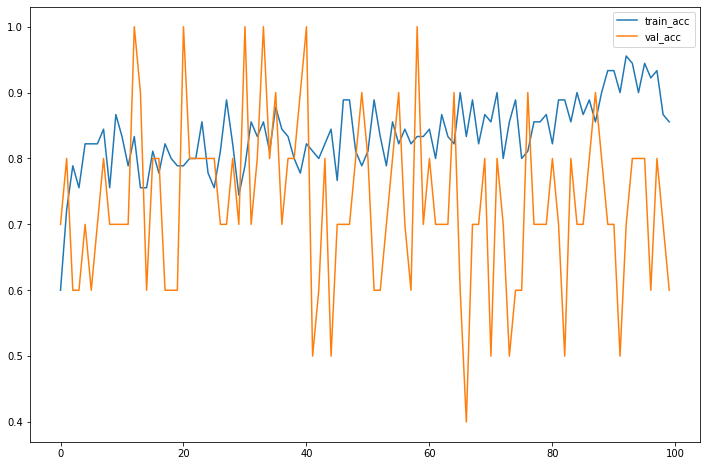

In [31]:
plt.plot(lr_h.history['acc'], label='train_acc')
plt.plot(lr_h.history['val_acc'], label='val_acc')
plt.legend()

In [21]:
lr_model.save('Models/LogisticRegression_100Epochs.h5')

In [9]:
## Single Layer LSTM Model

In [ ]:
# from keras.models import Sequential
# from keras.layers import Dense, BatchNormalization, Dropout
# from keras.layers import LSTM
# from keras import regularizers

# lstm_model = Sequential()
# lstm_model.add(BatchNormalization(input_shape=(None, 128)))
# lstm_model.add(Dropout(0.5))
# lstm_model.add(LSTM(128, activation='relu',
#         kernel_regularizer=regularizers.l2(0.01),
#         activity_regularizer=regularizers.l2(0.01)))
# lstm_model.add(Dense(1, activation='sigmoid'))

# # try using different optimizers and different optimizer configs
# lstm_model.compile(loss='binary_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])